In [5]:
!pip install polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.3 MB/s eta 0:00:00


In [14]:
from polygon import RESTClient
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pytz
import math
import time
from datetime import datetime, timedelta
from IPython.display import display, Markdown

# сюда вставить свой API key c polygon.io
api_key = "azrYnQB4M7azl2eFpGC4TALaQ0koOLes"
PAID_POLYGON_SUBSCRIPTION = False

symbol = "TQQQ"
from_date = "2024-01-01"
to_date = "2025-08-15"


OUTPUT_FILE = f"{symbol}_unadjusted.csv"
utc_tz = pytz.timezone('UTC')
nyc_tz = pytz.timezone('America/New_York')

In [15]:
# download data funcs
def get_polygon_data(url=None, ticker=symbol, multiplier=1, timespan="minute",
                       from_date=from_date, to_date=to_date, adjusted=False):
    if url is None:
        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
        params = {
            "adjusted": "true" if adjusted else "false",
            "sort": "asc",
            "limit": 50000,
            "apiKey": api_key
        }
        response = requests.get(url, params=params)
    else:
        if "apiKey" not in url:
            url = f"{url}&apiKey={api_key}" if "?" in url else f"{url}?apiKey={api_key}"
        response = requests.get(url)

    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None, None

    data = response.json()
    next_url = data.get("next_url")
    if next_url and "apiKey" not in next_url:
        next_url = f"{next_url}&apiKey={api_key}" if "?" in next_url else f"{next_url}?apiKey={api_key}"

    return data.get("results", []), next_url

def get_daily_adjusted_data():
    ATR_START_DATE = (datetime.strptime(from_date, '%Y-%m-%d') - timedelta(days=30)).strftime('%Y-%m-%d')

    print("Fetching daily adjusted data for ATR calculation...")
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{ATR_START_DATE}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "asc",
        "limit": 50000,
        "apiKey": api_key
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"Error getting daily data: {response.status_code}")
        print(response.text)
        return pd.DataFrame()

    data = response.json().get("results", [])
    if not data:
        print("No daily data found.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    df['datetime_utc'] = pd.to_datetime(df['t'], unit='ms')
    df['datetime_et'] = df['datetime_utc'].dt.tz_localize(utc_tz).dt.tz_convert(nyc_tz)
    df['day'] = df['datetime_et'].dt.date.astype(str)
    df = df.rename(columns={'o': 'dOpen', 'h': 'dHigh', 'l': 'dLow', 'c': 'dClose', 'v': 'dVolume'})
    df = calculate_atr(df, period=14)
    df = df[df['datetime_et'] >= pd.Timestamp(from_date, tz=nyc_tz)].copy()
    return df[['day', 'dOpen', 'ATR']]

# Data Processing

def calculate_atr(df, period=14):
    if 'dHigh' not in df.columns or 'dLow' not in df.columns or 'dClose' not in df.columns:
        print("Missing required columns for ATR calculation")
        return df

    df = df.copy()
    df['prev_close'] = df['dClose'].shift(1)
    df['HC'] = abs(df['dHigh'] - df['prev_close'])
    df['LC'] = abs(df['prev_close'] - df['dLow'])
    df['HL'] = abs(df['dHigh'] - df['dLow'])
    df['TR'] = df[['HC', 'LC', 'HL']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period, min_periods=1).mean()
    df['ATR'] = df['ATR'].shift(1)
    df.drop(['prev_close', 'HC', 'LC', 'HL', 'TR'], axis=1, inplace=True)
    return df

def process_data(results):
    if not results:
        return pd.DataFrame()

    df = pd.DataFrame(results)
    df['datetime_utc'] = pd.to_datetime(df['t'], unit='ms')
    df['datetime_et'] = df['datetime_utc'].dt.tz_localize(utc_tz).dt.tz_convert(nyc_tz)
    df['caldt'] = df['datetime_et'].dt.tz_localize(None)

    # Filter to regular market hours (9:30-15:59 ET)
    df = df.set_index('datetime_et')
    market_data = df.between_time('09:30', '15:59').reset_index()

    market_data['date'] = market_data['datetime_et'].dt.date
    market_data = market_data.rename(columns={
        'v': 'volume',
        'vw': 'vwap',
        'o': 'open',
        'c': 'close',
        'h': 'high',
        'l': 'low',
        't': 'timestamp_ms',
        'n': 'transactions'
    })
    market_data['day'] = market_data['date'].astype(str)

    return market_data

def download_and_merge_data():
    if not PAID_POLYGON_SUBSCRIPTION:
        two_years_ago = datetime.now() - timedelta(days=730)
        start_dt = datetime.strptime(from_date, '%Y-%m-%d')
        if start_dt < two_years_ago:
            print("ERROR: For free Polygon subscriptions, START_DATE must be within the past 2 years.")
            return None

    daily_adjusted_data = get_daily_adjusted_data()
    if daily_adjusted_data.empty:
        print("Unable to get adjusted daily data. Exiting.")
        return None
    all_raw_data = []
    next_url = None
    batch_count = 0
    print(f"Downloading intraday data for {symbol} from {from_date}...")

    while True:
        batch_count += 1
        print(f"Batch {batch_count}...")
        results, next_url = get_polygon_data(url=next_url, adjusted=False)
        if not results:
            print("No more data.")
            break

        # Just add raw results to our collection, don't process yet
        all_raw_data.extend(results)
        print(f"Batch {batch_count}: Retrieved {len(results)} records")

        if not next_url:
            print("Download complete.")
            break

        if not PAID_POLYGON_SUBSCRIPTION:
            time.sleep(12)

    if all_raw_data:
        print(f"Processing {len(all_raw_data)} total records...")
        final_df = process_data(all_raw_data)

        if not final_df.empty:
            final_df = pd.merge(final_df, daily_adjusted_data, on='day', how='left')
            final_df['caldt'] += pd.Timedelta(minutes=1)
            cols = ['caldt', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'day', 'dOpen', 'ATR']
            available_cols = [col for col in cols if col in final_df.columns]
            final_df[available_cols].to_csv(OUTPUT_FILE, index=False)
            print(f"Data saved to {OUTPUT_FILE}")
            print(f"Total records: {len(final_df)}")
            return final_df
        else:
            print("No data after processing.")
            return None
    else:
        print("No data collected.")
        return None


# Performance Analysis & Backtesting Functions

def price2return(price, n=1):
    price = np.array(price)
    T = len(price)
    y = np.full_like(price, np.nan, dtype=float)
    if T > n:
        y[n:] = price[n:] / price[:T-n] - 1
    return y

def summary_statistics(dailyReturns):
    riskFreeRate = 0
    tradingDays = 252
    dailyReturns = np.array(dailyReturns)
    dailyReturns = dailyReturns[~np.isnan(dailyReturns)]
    totalReturn = np.prod(1 + dailyReturns) - 1
    numYears = len(dailyReturns) / tradingDays
    CAGR = (1 + totalReturn)**(1/numYears) - 1
    volatility = np.std(dailyReturns, ddof=0) * np.sqrt(tradingDays)
    sharpeRatio = (np.mean(dailyReturns) - riskFreeRate/tradingDays) / np.std(dailyReturns, ddof=0) * np.sqrt(tradingDays)
    nav = np.cumprod(1 + dailyReturns)
    peak = np.maximum.accumulate(nav)
    drawdown = (nav - peak) / peak
    MDD = np.min(drawdown)
    metrics = ["Total Return (%)", "CAGR (%)", "Volatility (%)", "Sharpe Ratio", "Max Drawdown (%)"]
    values = [totalReturn*100, CAGR*100, volatility*100, sharpeRatio, MDD*100]
    formatted_values = [f"{v:.4f}" if i < 3 or i == 4 else f"{v:.6f}" for i,v in enumerate(values)]
    performance_table = pd.DataFrame({'Metric': metrics, 'Value': formatted_values})
    return performance_table

def monthly_performance_table(returns, dates):
    returns_series = pd.Series(returns, index=pd.DatetimeIndex(dates))
    returns_series = returns_series[~np.isnan(returns_series)]
    df = pd.DataFrame({'return': returns_series,
                       'year': returns_series.index.year,
                       'month': returns_series.index.month})
    monthly_returns = df.groupby(['year', 'month'])['return'].apply(lambda x: np.prod(1 + x) - 1).reset_index()
    pivot_table = monthly_returns.pivot(index='year', columns='month', values='return')
    pivot_table['Year Total'] = pivot_table.apply(lambda row: np.prod(1 + row.dropna()) - 1
                                                   if not row.dropna().empty else np.nan, axis=1)
    formatted_table = pivot_table.apply(lambda col: col.map(lambda x: f"{x*100:.2f}%" if not pd.isna(x) else ""))
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    formatted_table = formatted_table.rename(columns=month_names)
    return formatted_table

def backtest(days, p, orb_m, target_R, risk, max_Lev, AUM_0, commission):
    start_time = time.time()
    str_df = pd.DataFrame()
    str_df['Date'] = days
    str_df['AUM'] = np.nan
    str_df.loc[0, 'AUM'] = AUM_0
    str_df['pnl_R'] = np.nan
    or_candles = orb_m
    day_groups = dict(tuple(p.groupby(p['day'].dt.date)))
    trade_id = 0
    trade_log = []

    for t in range(1, len(days)):
        current_day = days[t].date()
        if current_day not in day_groups:
            str_df.loc[t, 'pnl_R'] = 0
            str_df.loc[t, 'AUM'] = str_df.loc[t-1, 'AUM']
            continue

        day_data = day_groups[current_day]
        if len(day_data) <= or_candles:
            str_df.loc[t, 'pnl_R'] = 0
            str_df.loc[t, 'AUM'] = str_df.loc[t-1, 'AUM']
            continue

        OHLC = day_data[['open', 'high', 'low', 'close']].values
        split_adj = OHLC[0, 0] / day_data['dOpen'].iloc[0]
        atr_raw = day_data['ATR'].iloc[0] * split_adj
        side = np.sign(OHLC[or_candles-1, 3] - OHLC[0, 0])
        entry = OHLC[or_candles, 0] if len(OHLC) > or_candles else np.nan


        if side == 1:
            stop = abs(np.min(OHLC[:or_candles, 2]) / entry - 1)
        elif side == -1:
            stop = abs(np.max(OHLC[:or_candles, 1]) / entry - 1)
        else:
            stop = np.nan

        if side == 0 or math.isnan(stop) or math.isnan(entry):
            str_df.loc[t, 'pnl_R'] = 0
            str_df.loc[t, 'AUM'] = str_df.loc[t-1, 'AUM']
            continue

        if entry == 0 or stop == 0:
            shares = 0
        else:
            shares = math.floor(min(str_df.loc[t-1, 'AUM'] * risk / (entry * stop),
                                    max_Lev * str_df.loc[t-1, 'AUM'] / entry))

        if shares == 0:
            str_df.loc[t, 'pnl_R'] = 0
            str_df.loc[t, 'AUM'] = str_df.loc[t-1, 'AUM']
            continue

        OHLC_post_entry = OHLC[or_candles:, :]

        exit_reason = None
        exit_idx    = None
        exit_price  = None

        if side == 1:  # Long trade
            stop_price   = entry * (1 - stop)
            target_price = entry * (1 + target_R * stop) if np.isfinite(target_R) else float('inf')

            stop_hits   = OHLC_post_entry[:, 2] <= stop_price
            target_hits = OHLC_post_entry[:, 1]  > target_price

            if np.any(stop_hits) and np.any(target_hits):
                idx_stop, idx_target = np.argmax(stop_hits), np.argmax(target_hits)
                if idx_target < idx_stop:
                    exit_idx   = idx_target
                    exit_price = max(target_price, OHLC_post_entry[idx_target, 0])
                    exit_reason = 'Target'
                else:
                    exit_idx   = idx_stop
                    exit_price = min(stop_price, OHLC_post_entry[idx_stop, 0])
                    exit_reason = 'Stop'
            elif np.any(stop_hits):
                exit_idx   = np.argmax(stop_hits)
                exit_price = min(stop_price, OHLC_post_entry[exit_idx, 0])
                exit_reason = 'Stop'
            elif np.any(target_hits):
                exit_idx   = np.argmax(target_hits)
                exit_price = max(target_price, OHLC_post_entry[exit_idx, 0])
                exit_reason = 'Target'
            else:  # EOD exit
                exit_idx   = -1
                exit_price = OHLC_post_entry[-1, 3]
                exit_reason = 'Close'

            PnL_T = exit_price - entry

        elif side == -1:  # Short trade
            stop_price   = entry * (1 + stop)
            target_price = entry * (1 - target_R * stop) if np.isfinite(target_R) else 0

            stop_hits   = OHLC_post_entry[:, 1] >= stop_price
            target_hits = OHLC_post_entry[:, 2]  < target_price

            if np.any(stop_hits) and np.any(target_hits):
                idx_stop, idx_target = np.argmax(stop_hits), np.argmax(target_hits)
                if idx_target < idx_stop:
                    exit_idx   = idx_target
                    exit_price = min(target_price, OHLC_post_entry[idx_target, 0])
                    exit_reason = 'Target'
                else:
                    exit_idx   = idx_stop
                    exit_price = max(stop_price, OHLC_post_entry[idx_stop, 0])
                    exit_reason = 'Stop'
            elif np.any(stop_hits):
                exit_idx   = np.argmax(stop_hits)
                exit_price = max(stop_price, OHLC_post_entry[exit_idx, 0])
                exit_reason = 'Stop'
            elif np.any(target_hits):
                exit_idx   = np.argmax(target_hits)
                exit_price = min(target_price, OHLC_post_entry[exit_idx, 0])
                exit_reason = 'Target'
            else:  # EOD exit
                exit_idx   = -1
                exit_price = OHLC_post_entry[-1, 3]
                exit_reason = 'Close'

            PnL_T = entry - exit_price


        str_df.loc[t, 'AUM'] = str_df.loc[t-1, 'AUM'] + shares * PnL_T - shares * commission * 2
        str_df.loc[t, 'pnl_R'] = (str_df.loc[t, 'AUM'] - str_df.loc[t-1, 'AUM']) / (risk * str_df.loc[t-1, 'AUM'])

        entry_ts = day_data['caldt'].iloc[or_candles]
        exit_ts  = day_data['caldt'].iloc[or_candles + exit_idx]

        trade_id += 1
        trade_log.append({
            'TradeID'     : trade_id,
            'Date'        : current_day,
            'Side'        : 'Long' if side == 1 else 'Short',
            'EntryTime'   : entry_ts,
            'EntryPx'     : entry,
            'StopPx'      : stop_price,
            'TargetPx'    : target_price if np.isfinite(target_R) else np.nan,
            'ExitTime'    : exit_ts,
            'ExitPx'      : exit_price,
            'ExitReason'  : exit_reason,
            'Shares'      : shares,
            'PnL_$'       : shares * PnL_T,
            'PnL_R'       : (shares * PnL_T) / (risk * str_df.loc[t-1, 'AUM']),
            'AUM_After'   : str_df.loc[t, 'AUM']
        })

    end_time = time.time()
    print(f"******** Optimized Backtest Completed in {round(end_time - start_time, 2)} seconds! ********")
    print(f"Starting AUM: ${AUM_0:,.2f}")
    print(f"Final AUM: ${str_df['AUM'].iloc[-1]:,.2f}")
    print(f"Total Return: {(str_df['AUM'].iloc[-1]/AUM_0 - 1)*100:.4f}%")

    trades_df = pd.DataFrame(trade_log)

    return str_df, trades_df

def plot_equity_curve(str_df, AUM_0, orb_m, target_R, ticker):
    fig, ax = plt.subplots(figsize=(12, 7))
    df_plot = str_df.copy()
    if 'Date' in df_plot.columns:
        df_plot = df_plot.set_index('Date')
    try:
        weekly_data = df_plot['AUM'].resample('W').last().dropna()
    except Exception as e:
        print("Resampling failed, using original data.", e)
        weekly_data = df_plot['AUM'].dropna()

    p1, = ax.plot(weekly_data.index, weekly_data.values, 'r-', linewidth=2, label='Equity')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=90)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    ax.grid(True, linestyle=':')

    min_val = weekly_data.min() if not weekly_data.empty else AUM_0
    max_val = weekly_data.max() if not weekly_data.empty else AUM_0
    ax.set_ylim([0.9 * min_val, 1.25 * max_val])

    target_str = f"Target {target_R}R" if np.isfinite(target_R) else "No Target"
    ax.set_title(f"{orb_m}m-ORB - Stop @ OR High/Low - {target_str}\nFull Period - Ticker = {ticker}", fontsize=12)

    # Highlight out-of-sample period starting from a specific date
    start_date = datetime(2023, 2, 17)
    if not weekly_data.empty and start_date >= weekly_data.index[0] and start_date <= weekly_data.index[-1]:
        p2 = ax.axvspan(start_date, weekly_data.index[-1], alpha=0.1, color='green', label='Out-of-Sample')
        ax.legend(handles=[p1, p2], loc='upper left')
    else:
        ax.legend(loc='upper left')

    ax.set_yscale('log')
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs=None))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    return fig, ax


data = download_and_merge_data()
if data is None:
    raise Exception("Data download failed.")

# Load the exported intraday data
p = pd.read_csv(OUTPUT_FILE, parse_dates=['caldt', 'day'])
days = pd.to_datetime(p['day'].unique())
days = pd.DatetimeIndex(sorted(days))
days

Fetching daily adjusted data for ATR calculation...
Batch 1...
Batch 1: Retrieved 50000 records
Batch 2...
Batch 2: Retrieved 50000 records
Batch 3...
Batch 3: Retrieved 50000 records
Batch 4...
Batch 4: Retrieved 50000 records
Batch 5...
Batch 5: Retrieved 50000 records
Batch 6...
Batch 6: Retrieved 50000 records
Batch 7...
Batch 7: Retrieved 50000 records
Batch 8...
Batch 8: Retrieved 25251 records
Download complete.
Processing 375251 total records...
Data saved to TQQQ_unadjusted.csv
Total records: 158014


DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
               '2024-01-12', '2024-01-16',
               ...
               '2025-08-04', '2025-08-05', '2025-08-06', '2025-08-07',
               '2025-08-08', '2025-08-11', '2025-08-12', '2025-08-13',
               '2025-08-14', '2025-08-15'],
              dtype='datetime64[ns]', length=407, freq=None)

******** Optimized Backtest Completed in 0.38 seconds! ********
Starting AUM: $25,000.00
Final AUM: $49,650.91
Total Return: 98.6036%
     TradeID        Date   Side           EntryTime  EntryPx   StopPx  \
0          1  2024-01-03   Long 2024-01-03 09:36:00   47.190  46.9212   
1          2  2024-01-04   Long 2024-01-04 09:36:00   46.100  45.7800   
2          3  2024-01-05   Long 2024-01-05 09:36:00   46.170  45.7650   
3          4  2024-01-08   Long 2024-01-08 09:36:00   46.660  46.3300   
4          5  2024-01-09   Long 2024-01-09 09:36:00   48.045  47.6600   
..       ...         ...    ...                 ...      ...      ...   
399      400  2025-08-11  Short 2025-08-11 09:36:00   91.880  92.3950   
400      401  2025-08-12   Long 2025-08-12 09:36:00   92.950  92.1655   
401      402  2025-08-13   Long 2025-08-13 09:36:00   96.220  95.8600   
402      403  2025-08-14   Long 2025-08-14 09:36:00   94.370  93.6400   
403      404  2025-08-15  Short 2025-08-15 09:36:00   93.870  9

### Performance Summary

,Metric,Value
0,Total Return (%),98.6036
1,CAGR (%),53.0938
2,Volatility (%),49.0788
3,Sharpe Ratio,1.092542
4,Max Drawdown (%),-28.1300


### Monthly Performance

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year Total
year,,,,,,,,,,,,,
2024,-11.65%,-3.91%,-7.81%,1.25%,8.17%,-7.29%,26.60%,-0.86%,9.56%,-4.88%,4.17%,19.92%,29.85%
2025,5.02%,17.51%,2.33%,14.47%,-4.22%,-8.82%,10.99%,9.17%,,,,,52.95%


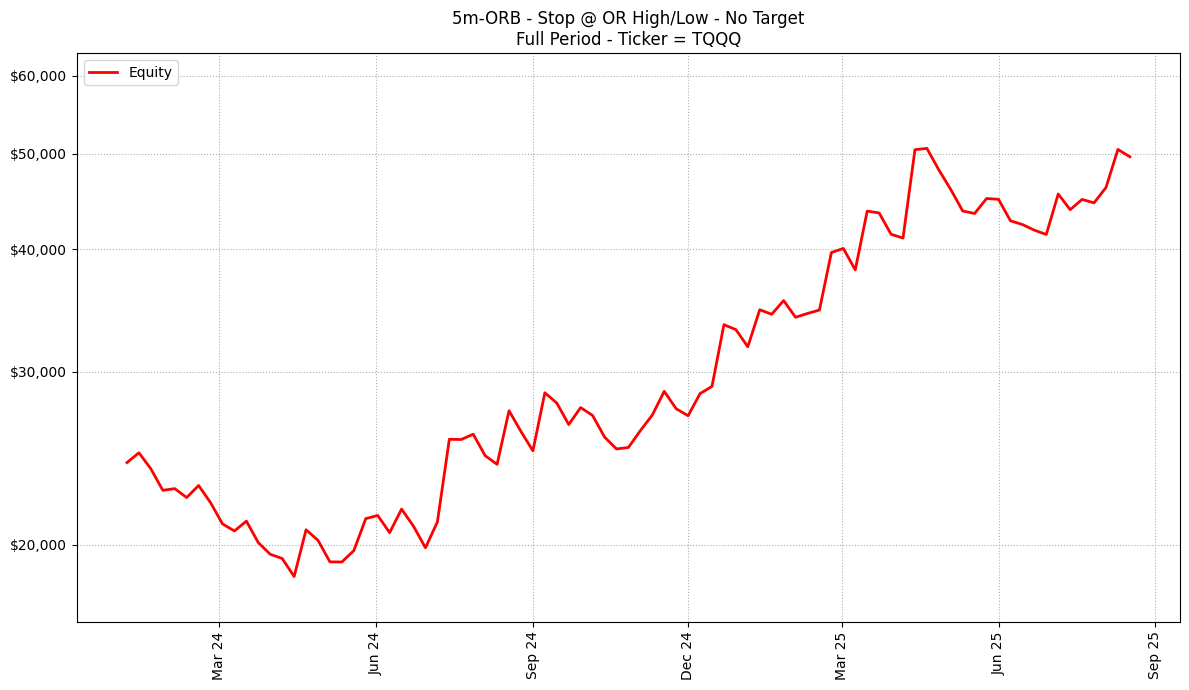

In [16]:
orb_m       = 5             # Opening Range (minutes)
target_R    = float('inf')  # Profit target (use inf for no target)
commission  = 0.0005        # Commission per share
risk        = 0.01          # Equity risk per trade (1% of AUM)
max_Lev     = 4             # Maximum leverage
AUM_0       = 25000         # Starting capital


str_df, trade_df = backtest(days, p, orb_m, target_R, risk, max_Lev, AUM_0, commission)

print(trade_df)

trade_df.to_csv('trade_details.csv', index=False)

returns = price2return(str_df['AUM'].values)

display(Markdown("### Performance Summary"))
summary_stats = summary_statistics(returns)
display(summary_stats)

display(Markdown("### Monthly Performance"))
monthly_table = monthly_performance_table(returns, str_df['Date'])
display(monthly_table)

# визуализация прибыли
fig, ax = plot_equity_curve(str_df, AUM_0, orb_m, target_R, symbol)
plt.tight_layout()
plt.show()